## Rescale model score by bad rate
---

Do the bad rate alignment on predicted probability before scaling it to score

In [1]:
import sys, os, json
sys.path.insert(1, "../../")
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle as pkl
import seaborn as sns

import src.monitoring.utils as mu

%matplotlib inline
plt.style.use('seaborn')

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

In [2]:
mmonth = "202103"
s3_base_path = f"s3://sofi-data-science/jxu/money-risk-models/customer-risk-model/monitor/{mmonth}"
# train_df = pd.read_parquet(os.path.join(s3_base_path, "dev_train_20201201_scored.parquet"))
test_df = pd.read_parquet(os.path.join(s3_base_path, "dev_test_20201201_scored.parquet"))

pred_cols = ['score_20191231', 
             'score_20201130_wo_ind', 
             'score_20201130_w_ind']

# produce active indicator
# had transactions in the past 30 days
test_df["is_active"] = (test_df.nr_past_transactions > 0) & (test_df.nr_transactions_30d > 0)
df_ = test_df[test_df.is_active]

In [3]:
display(test_df.is_active.value_counts(normalize=True))
display(test_df.is_active.value_counts(normalize=False))


False    0.83278
True     0.16722
Name: is_active, dtype: float64

False    474891
True      95357
Name: is_active, dtype: int64

### Model Performance
---

In [4]:
import src.monitoring.monitoring as mntr

plt.style.use("seaborn")

#### Full Population

In [5]:
report = mntr.get_pred_reports(test_df, "target", pred_cols, dropna=True)
report

,auc,ap,ks
score_20191231,74.70,16.18,32.52
score_20201130_wo_ind,52.23,1.99,7.37
score_20201130_w_ind,92.26,42.31,69.52


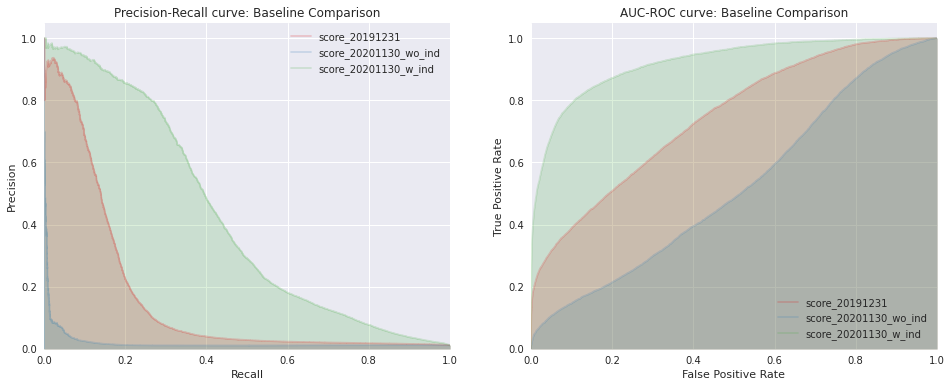

In [6]:
mntr_path = "./artifacts"
mntr.save_valid_performance_plots(
        {"20201201": test_df}, "target", pred_cols, mntr_path, dropna=False
    )

#### Active accounts

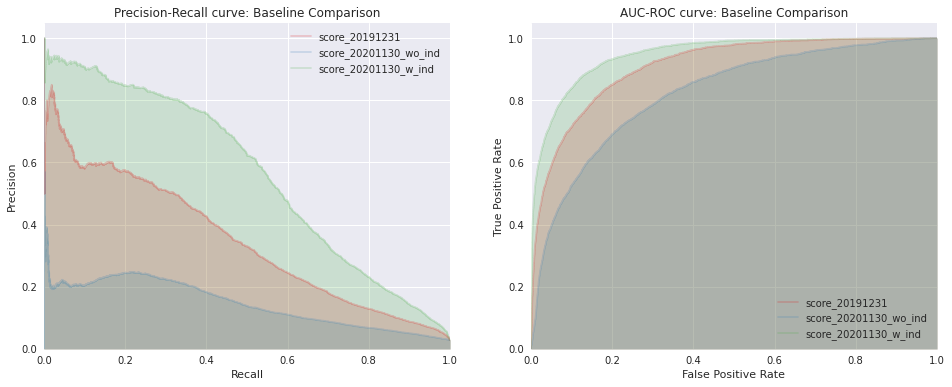

In [7]:
test_df["is_active"] = (test_df.nr_past_transactions > 0) & (test_df.nr_transactions_30d > 0)
df_ = test_df[test_df.is_active]

mntr_path = "./artifacts"
mntr.save_valid_performance_plots(
        {"20201201-active": df_}, "target", pred_cols, mntr_path, dropna=False
    )

In [8]:
report = mntr.get_pred_reports(df_, "target", pred_cols, dropna=True)
report

,auc,ap,ks
score_20191231,91.10,34.90,65.36
score_20201130_wo_ind,82.33,14.55,49.55
score_20201130_w_ind,94.91,56.37,75.23


### On RGs
---

In [9]:
sample_rate = 0.1
if 0 <= sample_rate < 1:
    df_ = df_.sample(frac=sample_rate)
else:
    df_ = test_df

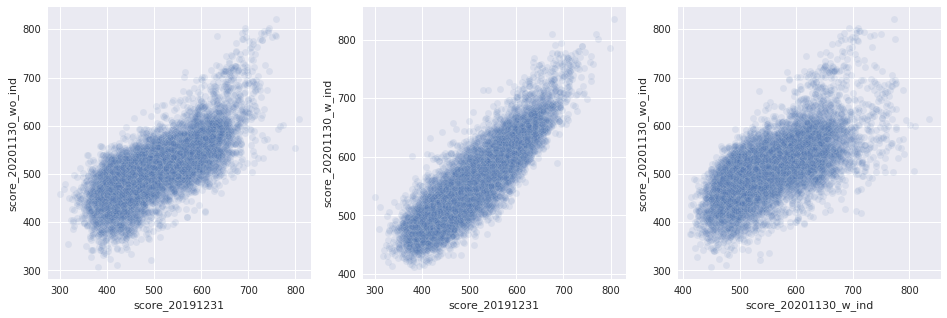

In [10]:
fig, axs = plt.subplots(1,3, figsize=(16, 5))
sns.scatterplot(x=df_.score_20191231, 
                y=df_.score_20201130_wo_ind, 
                alpha=0.1,
                ax=axs[0])
sns.scatterplot(x=df_.score_20191231, 
                y=df_.score_20201130_w_ind, 
                alpha=0.1,
                ax=axs[1])
sns.scatterplot(x=df_.score_20201130_w_ind, 
                y=df_.score_20201130_wo_ind, 
                alpha=0.1,
                ax=axs[2])
plt.show()

In [11]:
pred_cols = ["score_20191231", "score_20201130_wo_ind", "score_20201130_w_ind"]
test_df[pred_cols].corr()

,score_20191231,score_20201130_wo_ind,score_20201130_w_ind
score_20191231,1.000000,0.861099,0.696113
score_20201130_wo_ind,0.861099,1.000000,0.474929
score_20201130_w_ind,0.696113,0.474929,1.000000


#### Rank Order vs. Rank Order
---

<AxesSubplot:xlabel='rank_score_20191231', ylabel='rank_score_20201130_w_ind'>

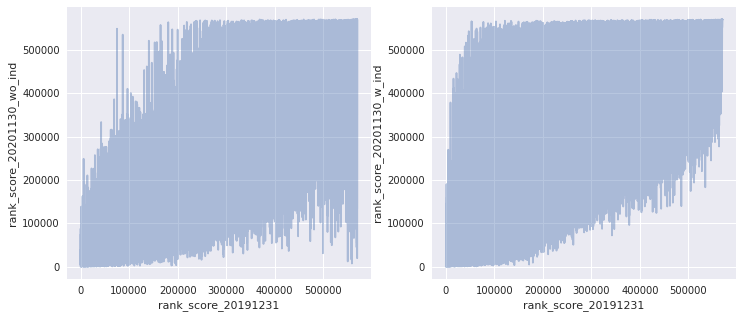

In [12]:
df_ = test_df.copy()

df_.sort_values(by=["score_20191231"], inplace=True)
df_["rank_score_20191231"] = range(len(df_))

df_.sort_values(by=["score_20201130_wo_ind"], inplace=True)
df_["rank_score_20201130_wo_ind"] = range(len(df_))

df_.sort_values(by=["score_20201130_w_ind"], inplace=True)
df_["rank_score_20201130_w_ind"] = range(len(df_))

idx = range(1, len(df_), 10)

fig, axs = plt.subplots(1,2, figsize=(12, 5))

sns.lineplot(data=df_.iloc[idx, :], x="rank_score_20191231", y="rank_score_20201130_wo_ind", alpha=0.4, ax=axs[0])
sns.lineplot(data=df_.iloc[idx, :], x="rank_score_20191231", y="rank_score_20201130_w_ind", alpha=0.4, ax=axs[1])

### RG Rescaling
---
Methods
* Score alignment using optimizer
* Score alignment based on bad rate

#### Optimizer - Trying to match score distribution

#### Based on Cumulated bad rate

In [13]:
pred_cols = ['pred_20191231', 
             'pred_20201130_wo_ind', 
             'pred_20201130_w_ind']
test_df[pred_cols].head()

,pred_20191231,pred_20201130_wo_ind,pred_20201130_w_ind
12703,0.001044,0.005176,0.014136
17074,0.786693,0.273061,0.965468
19216,0.853470,0.225040,0.964090
31532,0.907194,0.868007,0.973137
37589,0.001542,0.008525,0.082503


In [14]:
import rdsutils.score_alignment as sa

In [15]:
src_pred = "pred_20201130_w_ind"
tgt_pred = "pred_20191231"
target_col = "target"

br_tbl = sa.get_score_alignment_table(test_df, src_pred, tgt_pred, target_col,
                                   br_precision = 3, pred_precision = 3)
test_df[src_pred + "_rescaled"] = sa.get_aligned_score(test_df, br_tbl, src_pred, tgt_pred,
                                                    pred_precision=3)

source column:  pred_20201130_w_ind
target columns:  pred_20191231


In [16]:
def get_risk_groups(serie):
    return pd.cut(serie.round(), [300, 474, 510, 560, 600, 850], 
                  right=True, labels=[f'RG{i}' for i in range(1, 6)])

print("rescaled prediction column: ", src_pred+"_rescaled")
test_df["score_rescaled_20201130_w_ind_bad_rate"] = mu.scale_scores(test_df[src_pred+"_rescaled"])
test_df["rg_rescaled_20201130_w_ind_bad_rate"] = get_risk_groups(test_df["score_rescaled_20201130_w_ind_bad_rate"])

rescaled prediction column:  pred_20201130_w_ind_rescaled


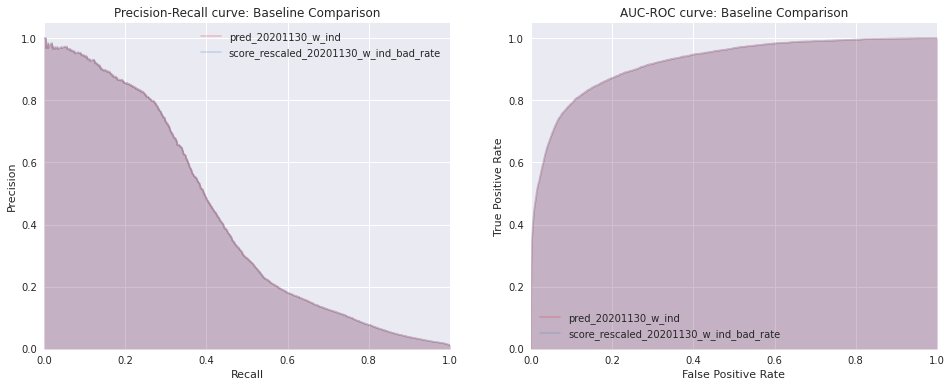

In [17]:
# make sure we scaled the correct score by looking at pr/auc with the old score - they should match

mntr_path = "./artifacts"
score_cols = ['pred_20201130_w_ind', 'score_rescaled_20201130_w_ind_bad_rate']
mntr.save_valid_performance_plots(
        {"20201201": test_df}, "target", score_cols, mntr_path, dropna=False
    )
# looks good, they match!

(570248, 109)

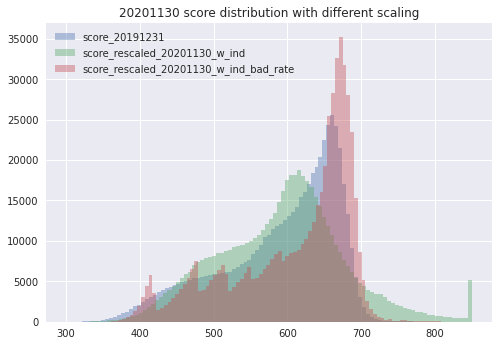

In [18]:
df_ = test_df#[~test_df.is_active 
             # & ~test_df.target]
display(df_.shape)

score_col = "score_20191231"
df_[score_col].hist(bins=100, alpha=0.4, label=score_col)

score_col = "score_rescaled_20201130_w_ind"
df_[score_col].hist(bins=100, alpha=0.4, label=score_col)

score_col = "score_rescaled_20201130_w_ind_bad_rate"
df_[score_col].hist(bins=100, alpha=0.4, label=score_col)

plt.title("20201130 score distribution with different scaling")
plt.legend()

(471246, 109)

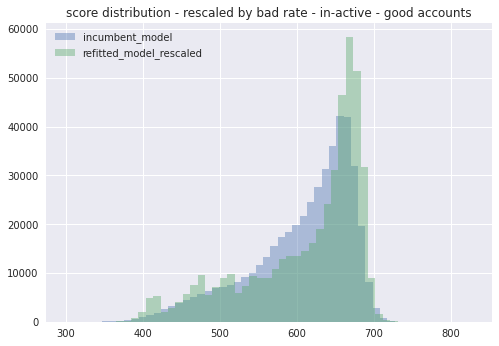

In [19]:
# score on the in active set
# activess defined as the group that had transaction in the past 30 days
df_ = test_df[~test_df.is_active 
              & ~test_df.target]
display(df_.shape)

score_col = "score_20191231"
df_[score_col].hist(bins=50, alpha=0.4, label="incumbent_model")

score_col = "score_rescaled_20201130_w_ind_bad_rate"
df_[score_col].hist(bins=50, alpha=0.4, label="refitted_model_rescaled")

plt.title("score distribution - rescaled by bad rate - in-active - good accounts")
plt.legend()
plt.savefig("./artifacts/score_distr_inactive.png")

In [20]:
def plot_score_distr(df, ax, title):
    score_col = "score_20191231"
    df[score_col].hist(bins=50, alpha=0.4, label="incumbent_model", ax=ax)

    score_col = "score_rescaled_20201130_w_ind_bad_rate"
    df[score_col].hist(bins=50, alpha=0.4, label="refitted_model_rescaled", ax=ax)
    
    ax.set_title(title)
    ax.legend()

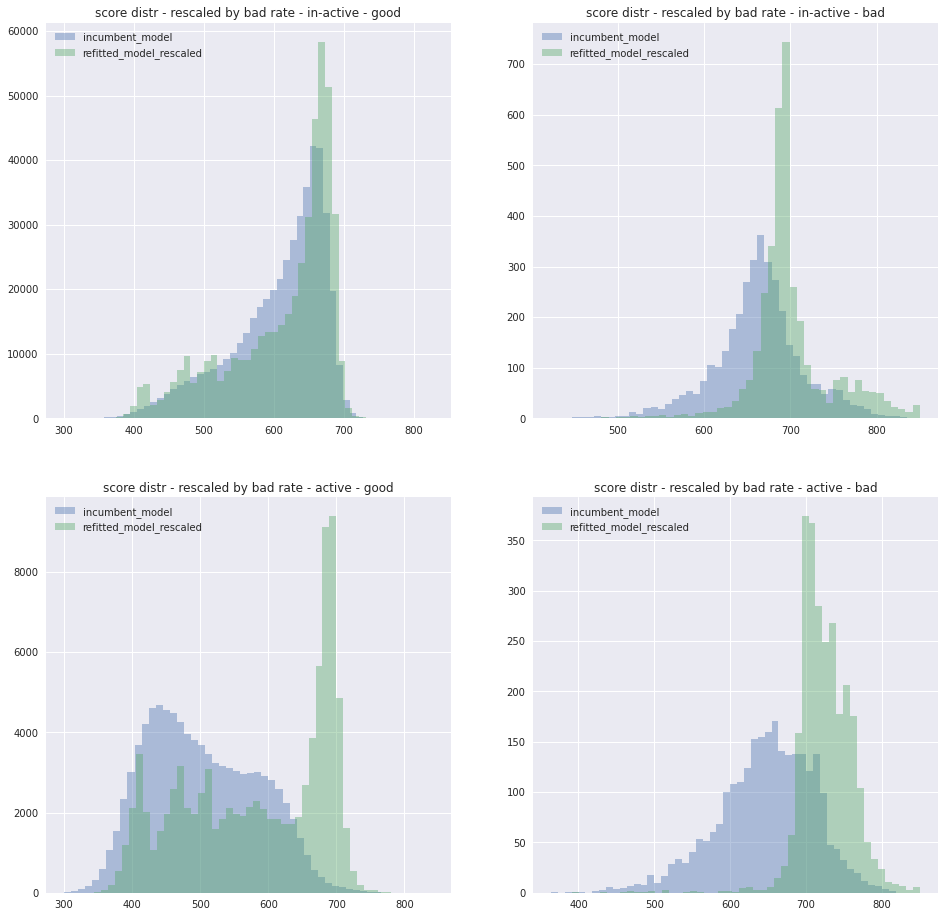

In [21]:
# plot 4x4
fig, axs = plt.subplots(2,2, figsize=(16, 16))

df_ = test_df[~test_df.is_active & ~test_df.target]  # inactive good accounts
plot_score_distr(df_, axs[0, 0], "score distr - rescaled by bad rate - in-active - good")

df_ = test_df[~test_df.is_active & test_df.target]  # inactive bad accounts
plot_score_distr(df_, axs[0, 1], "score distr - rescaled by bad rate - in-active - bad")

df_ = test_df[test_df.is_active & ~test_df.target]  # active good accounts
plot_score_distr(df_, axs[1, 0], "score distr - rescaled by bad rate - active - good")

df_ = test_df[test_df.is_active & test_df.target]  # active bad accounts
plot_score_distr(df_, axs[1, 1], "score distr - rescaled by bad rate - active - bad")

plt.savefig("./artifacts/score_distr_by_activenss_n_target.png")

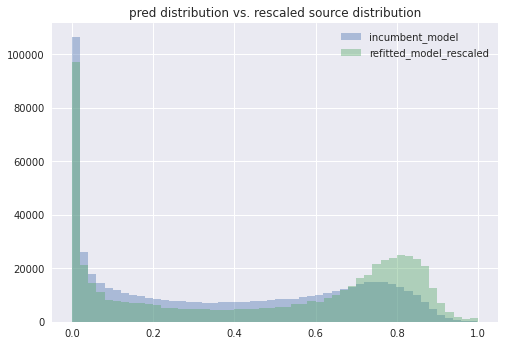

In [22]:
test_df[tgt_pred].hist(bins=50, alpha=0.4, label="incumbent_model")
test_df[src_pred+"_rescaled"].hist(bins=50, alpha=0.4, label="refitted_model_rescaled")
plt.title("pred distribution vs. rescaled source distribution")
plt.legend()
plt.savefig("./artifacts/pred_distr.png")

Text(0.5, 1.0, 'Risk Group Shift - include indeterminant - scaled by bad rate')

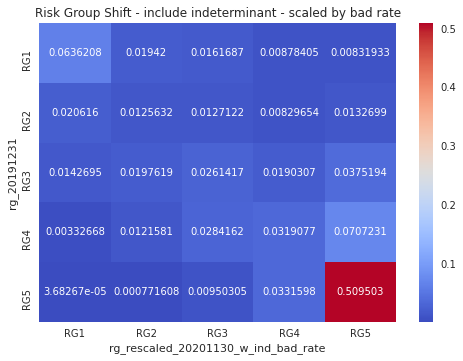

In [23]:
# look at risk groups
table = test_df[['rg_20191231', 'rg_rescaled_20201130_w_ind_bad_rate']].value_counts(normalize=True).sort_index().reset_index()
table.columns = ['rg_20191231', 'rg_rescaled_20201130_w_ind_bad_rate', 'counts']
table = pd.pivot_table(table, values='counts', index='rg_20191231', 
                       columns='rg_rescaled_20201130_w_ind_bad_rate', fill_value=0)
fig = plt.figure()
sns.heatmap(table, cmap='coolwarm', annot=True, fmt='.6g')
plt.title('Risk Group Shift - include indeterminant - scaled by bad rate')

In [24]:
print("ratio of users kept their RG: ", np.trace(table))

ratio of users kept their RG:  0.643736474945549


In [25]:
np.triu(table, 1)

array([[0.        , 0.01941996, 0.01616869, 0.00878405, 0.00831933],
       [0.        , 0.        , 0.01271224, 0.00829654, 0.0132699 ],
       [0.        , 0.        , 0.        , 0.01903065, 0.03751942],
       [0.        , 0.        , 0.        , 0.        , 0.0707231 ],
       [0.        , 0.        , 0.        , 0.        , 0.        ]])

In [26]:
print("ratio that went down in RG: ", np.triu(table,1).sum())
print("ratio that went up in RG: ", np.triu(table.T,1).sum())

ratio that went down in RG:  0.2142438771179753
ratio that went up in RG:  0.14201964793647565


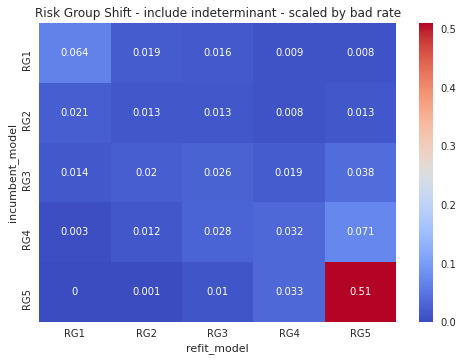

In [27]:
# look at risk groups
table = test_df[['rg_20191231', 'rg_rescaled_20201130_w_ind_bad_rate']].value_counts(normalize=True).sort_index().reset_index().round(3)
table.columns = ['incumbent_model', 'refit_model', 'counts']
table = pd.pivot_table(table, values='counts', index='incumbent_model', 
                       columns='refit_model', fill_value=0)
fig = plt.figure()
sns.heatmap(table, cmap='coolwarm', annot=True, fmt='.6g')
plt.title('Risk Group Shift - include indeterminant - scaled by bad rate')
plt.savefig("./artifacts/rg_shift.png")

### Visualize RG shifts
---

#### Trained excluding indeterminant - same scaling

Text(0.5, 1.0, 'Risk Group Shift - excluded indeterminant')

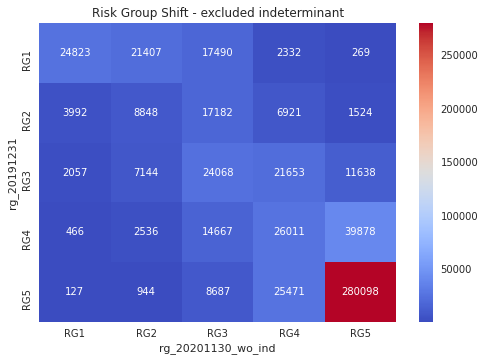

In [28]:
# compare the flow of risk groups 
table = test_df[['rg_20191231', 'rg_20201130_wo_ind']].value_counts().sort_index().reset_index()
table.columns = ['rg_20191231', 'rg_20201130_wo_ind', 'counts']
table = pd.pivot_table(table, values='counts', index='rg_20191231', 
                       columns='rg_20201130_wo_ind', fill_value=0)
fig = plt.figure()
sns.heatmap(table, cmap='coolwarm', annot=True, fmt='.6g')
plt.title('Risk Group Shift - excluded indeterminant')

Text(0.5, 1.0, 'Risk Group Shift - include indeterminant - scaled by bad rate')

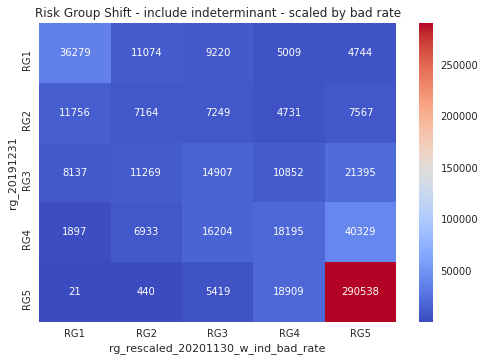

In [29]:
# look at risk groups
table = test_df[['rg_20191231', 'rg_rescaled_20201130_w_ind_bad_rate']].value_counts(normalize=False).sort_index().reset_index()
table.columns = ['rg_20191231', 'rg_rescaled_20201130_w_ind_bad_rate', 'counts']
table = pd.pivot_table(table, values='counts', index='rg_20191231', 
                       columns='rg_rescaled_20201130_w_ind_bad_rate', fill_value=0)
fig = plt.figure()
sns.heatmap(table, cmap='coolwarm', annot=True, fmt='.6g')
plt.title('Risk Group Shift - include indeterminant - scaled by bad rate')

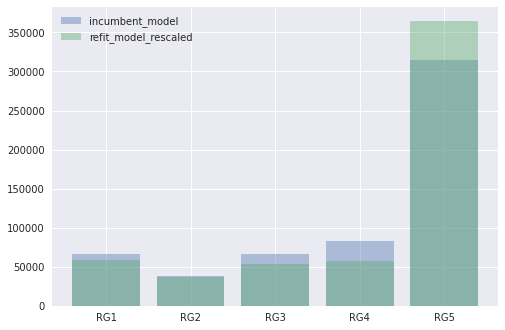

In [30]:
freq = test_df.rg_20191231.value_counts().sort_index()
plt.bar(freq.index, freq.values, label="incumbent_model", alpha=0.4)

freq = test_df.rg_rescaled_20201130_w_ind_bad_rate.value_counts().sort_index()
plt.bar(freq.index, freq.values, label="refit_model_rescaled", alpha=0.4)

plt.legend()
plt.savefig("./artifacts/rg_distr.png")

### Swap Set
---
Explaination by Experian: [here](http://www.experian.com/blogs/insights/2018/01/swap-set-measure-impact-model-changes/)

We compute bad rates within different segments, along with the total bad rate across each RG for both models.

In [31]:
import rdsutils.swap_set_analysis as ssa

In [32]:
rg1 = "rg_20191231"
rg2 = "rg_rescaled_20201130_w_ind_bad_rate"
rg_tbl = ssa.get_swapset_table(test_df, rg1, rg2)
tgt_tbl = ssa.get_target_counts_table(test_df, rg1, rg2, "target")

Text(0.5, 1.0, 'total users')

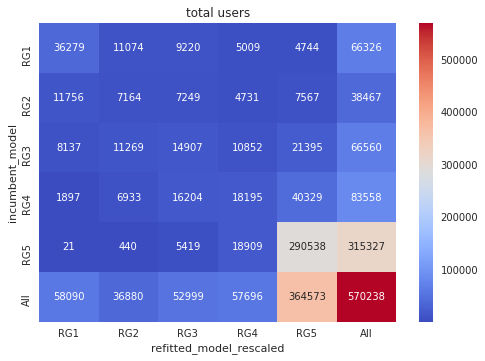

In [33]:
fig = plt.figure()
sns.heatmap(rg_tbl, cmap='coolwarm', annot=True, fmt='.6g')
plt.xlabel("refitted_model_rescaled")
plt.ylabel("incumbent_model")
plt.title('total users')

Text(0.5, 1.0, 'bad counts')

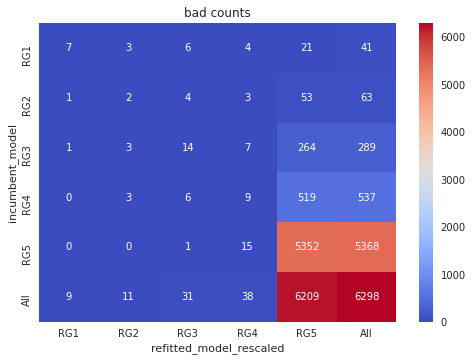

In [34]:
# plot those?
fig = plt.figure()
sns.heatmap(tgt_tbl, cmap='coolwarm', annot=True, fmt='.6g')
plt.xlabel("refitted_model_rescaled")
plt.ylabel("incumbent_model")
plt.title('bad counts')

In [35]:
tgt_tbl

rg_rescaled_20201130_w_ind_bad_rate,RG1,RG2,RG3,RG4,RG5,All
rg_20191231,,,,,,
RG1,7,3,6,4,21,41
RG2,1,2,4,3,53,63
RG3,1,3,14,7,264,289
RG4,0,3,6,9,519,537
RG5,0,0,1,15,5352,5368
All,9,11,31,38,6209,6298


In [36]:
swapset = ssa.get_swap_set_bad_rate(test_df, rg1, rg2, "target", margins=True)
swapset.style.background_gradient(cmap='coolwarm')

rg_rescaled_20201130_w_ind_bad_rate,RG1,RG2,RG3,RG4,RG5,All
rg_20191231,,,,,,
RG1,0.000193,0.000271,0.000651,0.000799,0.004427,0.000618
RG2,0.000085,0.000279,0.000552,0.000634,0.007004,0.001638
RG3,0.000123,0.000266,0.000939,0.000645,0.012339,0.004342
RG4,0.000000,0.000433,0.000370,0.000495,0.012869,0.006427
RG5,0.000000,0.000000,0.000185,0.000793,0.018421,0.017024
All,0.000155,0.000298,0.000585,0.000659,0.017031,0.011045


(<Figure size 864x360 with 4 Axes>,
 <AxesSubplot:title={'center':'rg shift: wo margins'}, xlabel='new model', ylabel='incumbent model'>)

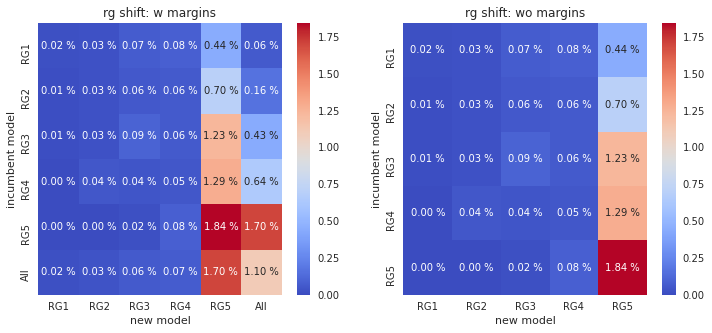

In [37]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
ssa.plot_swap_set_bad_rate(test_df, rg1, rg2, "target", margins=True, fig=fig, ax=axs[0],
                       title="rg shift: w margins",
                       xlabel="new model", ylabel="incumbent model")
ssa.plot_swap_set_bad_rate(test_df, rg1, rg2, "target", margins=False, fig=fig, ax=axs[1],
                       title="rg shift: wo margins",
                       xlabel="new model", ylabel="incumbent model")

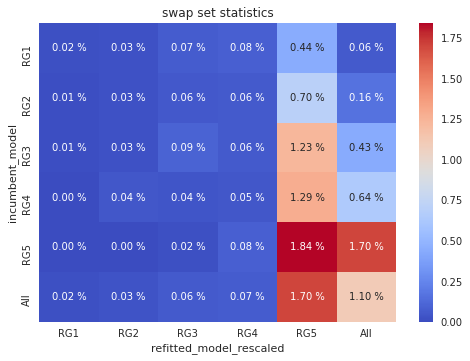

In [38]:
fig, ax = ssa.plot_swap_set_bad_rate(test_df, rg1, rg2, "target", margins=True,
                                     title="swap set statistics",
                                     xlabel="refitted_model_rescaled",
                                     ylabel="incumbent_model")
fig.savefig("./artifacts/swapset-stats.png")

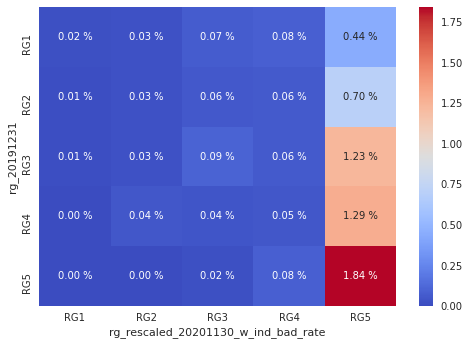

In [39]:
fig, ax = ssa.plot_swap_set_bad_rate(test_df, rg1, rg2, "target", margins=False)

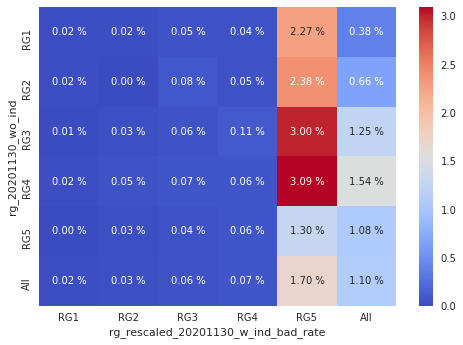

In [40]:
# how about swap set statistics on the two refit models
rg1_ = "rg_20201130_wo_ind"
rg2_ = "rg_rescaled_20201130_w_ind_bad_rate"
fig, ax = ssa.plot_swap_set_bad_rate(test_df, rg1_, rg2_, "target", margins=True)

### To David
---

In [41]:
cols_to_include = sorted(["borrower_id", "business_account_number", "target", "sample_date",
                   "score_rescaled_20201130_w_ind_bad_rate", "rg_rescaled_20201130_w_ind_bad_rate",
                   'pred_20191231', 'pred_20201130_wo_ind', 'pred_20201130_w_ind',
                   "score_rescaled_20201130_w_ind", 'score_20191231', 'rg_20191231'])

display(test_df[cols_to_include].head())
test_df[cols_to_include].to_csv("s3://sofi-data-science/jxu/monitoring/customer-risk-v1/2021-03/validation_df_20211201_only_scores.csv")

,borrower_id,business_account_number,pred_20191231,pred_20201130_w_ind,pred_20201130_wo_ind,rg_20191231,rg_rescaled_20201130_w_ind_bad_rate,sample_date,score_20191231,score_rescaled_20201130_w_ind,score_rescaled_20201130_w_ind_bad_rate,target
12703,2045135.0,410002346024,0.001044,0.014136,0.005176,RG1,RG2,2020-12-01,420.468318,491.450589,496.521455,False
17074,11199800.0,410010139461,0.786693,0.965468,0.273061,RG5,RG5,2020-12-01,672.159133,850.000000,739.176888,True
19216,11197353.0,410010124014,0.853470,0.964090,0.225040,RG5,RG5,2020-12-01,686.239774,850.000000,738.574849,True
31532,11212642.0,410010157744,0.907194,0.973137,0.868007,RG5,RG5,2020-12-01,702.193300,850.000000,742.475167,True
37589,6346948.0,410002553835,0.001542,0.082503,0.008525,RG1,RG5,2020-12-01,432.498815,600.328527,643.258624,False


In [42]:
test_df.to_parquet(os.path.join(s3_base_path, "dev_test_20201201_scored_w_scaled_by_bads.parquet"))